In [168]:
# The code is developed for the paper "Customer Segmentation Applied On RFM-ID Model"

# Imports

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Loading Data 

~ Data Description ~

InvoiceNo(Nominal): A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 

StockCode(Nominal): Product (item) code. A 5-digit integral number uniquely assigned to each distinct product. 

Description(String):  Product (item) name. 

Quantity(Numeric): The quantities of each product (item) per transaction.

InvoiceDate(Numeric): Invoice date and time. The day and time when a transaction was generated. 

UnitPrice(Numeric): Product price per unit in sterling (Â£). 

CustomerID(Nominal): A 5-digit integral number uniquely assigned to each customer. 

Country(Nominal): The name of the country where a customer resides.



In [170]:
df_dict = pd.read_excel('./data/online_retail.xlsx', sheet_name=None) # contains two excel sheets

In [171]:
df_1 = df_dict['Year 2009-2010']
df_2 = df_dict['Year 2010-2011']

df_c = pd.concat([df_1, df_2]) 

In [172]:
print(f"Number of records: {df_c.shape[0]}")

Number of records: 1067371


In [173]:
df_c.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [174]:
df_c.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [175]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


# Pre-processing

## Removing Null values

In [176]:
null_values_percentage = round(100*(df_c.isnull().sum())/len(df_c), 2)

In [177]:
null_values_percentage

Invoice         0.00
StockCode       0.00
Description     0.41
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.77
Country         0.00
dtype: float64

In [178]:
# As we see custoemr ID has around 22% percent of null values. We are will drop these columns.

In [179]:
df_proc = df_c.dropna() # pre-processed data frame (data_proc)

In [180]:
df_proc.describe()

,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


## Removing Negative values

In [181]:
df_proc = df_proc[~df_proc["Invoice"].str.contains("C", na = False)]

## Outliers

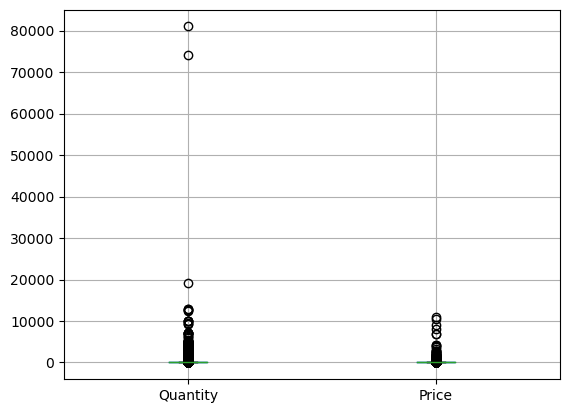

In [182]:
df_proc[["Quantity", "Price"]].boxplot()
plt.show() # Why this line made it to work?

In [183]:
# As we see, Quantity and Price have outliers. So, we will remove them.

In [184]:
# Removing outliers from Quantity
Q1 = df_proc.Quantity.quantile(0.25)
Q3 = df_proc.Quantity.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_proc = df_proc[(df_proc.Quantity>lower_limit)&(df_proc.Quantity<upper_limit)]


In [185]:
# Removing outliers from Price.
# Run this twice to remove all the outliers.
Q1 = df_proc.Price.quantile(0.25)
Q3 = df_proc.Price.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_proc = df_proc[(df_proc.Price>lower_limit)&(df_proc.Price<upper_limit)]


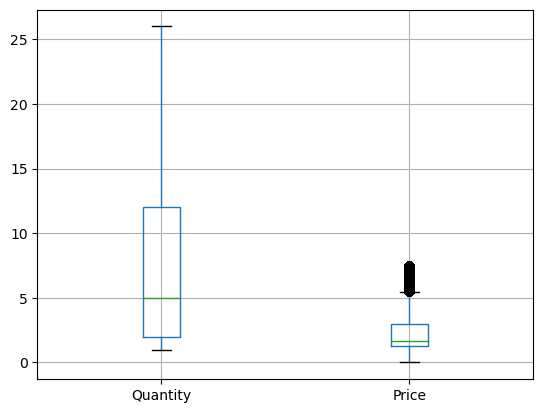

In [186]:
df_proc[["Quantity", "Price"]].boxplot()
plt.show() # Why this line made it to work?

In [187]:
df_proc.describe()

,Quantity,Price,Customer ID
count,686023.000000,686023.000000,686023.000000
mean,7.299531,2.269788,15362.101306
std,6.692578,1.599637,1694.422894
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,14019.000000
50%,5.000000,1.690000,15311.000000
75%,12.000000,2.950000,16841.000000
max,26.000000,7.490000,18287.000000


# RFM-ID Score

R(Recenecy): How recently did the customer purchase?

F(Frequency): How often do they purchase?

M(Monetary): How much do they spend?

I(Intenisty): How many do they buy per transaction?

D(Diversity): How many products do they buy?

In [188]:
df_proc.groupby('StockCode').agg({'Description': "nunique"}).sort_values(by='Description', ascending=False).head()

,Description
StockCode,
21955,4
22346,4
22345,4
22344,4
23196,4


In [189]:
# From the above table we can see that each StockCode has more than one description. This is maybe because of non-standard human input.

## RFM

In [190]:
# Recency

# Max date
df_proc['InvoiceDate'] = pd.to_datetime(df_proc['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = df_proc['InvoiceDate'].max()
max_date

# Different between max date and the transaction date
df_proc['Diff'] = max_date - df_proc['InvoiceDate']

# Last transaction date for each customer
rfm_r = df_proc.groupby('Customer ID')['Diff'].min().reset_index()
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r.columns =  ['Customer ID', 'Recency']
rfm_r.head(10)

,Customer ID,Recency
0,12346.0,528
1,12347.0,1
2,12348.0,248
3,12349.0,18
4,12350.0,309
5,12351.0,374
6,12352.0,35
7,12353.0,203
8,12354.0,231
9,12355.0,213


In [191]:
# Frequency
rfm_f = df_proc.groupby('Customer ID')['Invoice'].count().reset_index()
rfm_f.columns = ['Customer ID', 'Frequency']
rfm_f.head(10)


,Customer ID,Frequency
0,12346.0,33
1,12347.0,234
2,12348.0,26
3,12349.0,137
4,12350.0,16
5,12351.0,20
6,12352.0,83
7,12353.0,22
8,12354.0,40
9,12355.0,29


In [192]:
# Monetary 
df_proc['Total'] = df_proc['Price'] * df_proc['Quantity']
rfm_m = df_proc.groupby('Customer ID')['Total'].sum().reset_index()
rfm_m.columns = ['Customer ID', 'Monetary']
rfm_m.head(10)

,Customer ID,Monetary
0,12346.0,372.86
1,12347.0,4538.90
2,12348.0,312.36
3,12349.0,2620.04
4,12350.0,294.40
5,12351.0,288.18
6,12352.0,1461.99
7,12353.0,347.06
8,12354.0,682.69
9,12355.0,656.11


In [195]:
rfm = pd.merge(rfm_r, rfm_f, on='Customer ID', how='inner')
rfm = pd.merge(rfm, rfm_m, on='Customer ID', how='inner')
rfm.head(10)

,Customer ID,Recency,Frequency,Monetary
0,12346.0,528,33,372.86
1,12347.0,1,234,4538.90
2,12348.0,248,26,312.36
3,12349.0,18,137,2620.04
4,12350.0,309,16,294.40
5,12351.0,374,20,288.18
6,12352.0,35,83,1461.99
7,12353.0,203,22,347.06
8,12354.0,231,40,682.69
9,12355.0,213,29,656.11


## ID

In [193]:
# Intenisty
rfm_i = df_proc.groupby('Customer ID')['Quantity'].median().reset_index()
rfm_i.columns = ['Customer ID', 'Intenisty']
rfm_i.head(10)


,Customer ID,Intenisty
0,12346.0,1.0
1,12347.0,12.0
2,12348.0,24.0
3,12349.0,10.0
4,12350.0,12.0
5,12351.0,12.0
6,12352.0,6.0
7,12353.0,12.0
8,12354.0,8.0
9,12355.0,8.0


In [194]:
# Merging 

In [196]:
rfmi = pd.merge(rfm_r, rfm_f, on='Customer ID', how='inner')
rfmi = pd.merge(rfmi, rfm_m, on='Customer ID', how='inner')
rfmi = pd.merge(rfmi, rfm_i, on='Customer ID', how='inner')
rfmi.head(10)

,Customer ID,Recency,Frequency,Monetary,Intenisty
0,12346.0,528,33,372.86,1.0
1,12347.0,1,234,4538.90,12.0
2,12348.0,248,26,312.36,24.0
3,12349.0,18,137,2620.04,10.0
4,12350.0,309,16,294.40,12.0
5,12351.0,374,20,288.18,12.0
6,12352.0,35,83,1461.99,6.0
7,12353.0,203,22,347.06,12.0
8,12354.0,231,40,682.69,8.0
9,12355.0,213,29,656.11,8.0


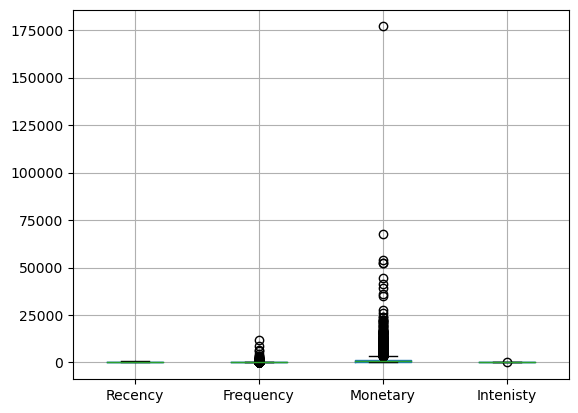

In [197]:
rfmi[['Recency', 'Frequency', 'Monetary', 'Intenisty']].boxplot()
plt.show()

## Scaling

In [157]:
# Should I remove outliers from the RFM values? - I don't know! 

In [158]:
# # Removing outliers from Frequency.
# Q1 = rfm.Frequency.quantile(0.25)
# Q3 = rfm.Frequency.quantile(0.75)
# IQR = Q3 - Q1
# lower_limit = Q1 - 1.5 * IQR
# upper_limit = Q3 + 1.5 * IQR

# rfm = rfm[(rfm.Frequency>lower_limit)&(rfm.Frequency<upper_limit)]


In [159]:
# # Removing outliers from Frequency.
# Q1 = rfm.Monetary.quantile(0.25)
# Q3 = rfm.Monetary.quantile(0.75)
# IQR = Q3 - Q1
# lower_limit = Q1 - 1.5 * IQR
# upper_limit = Q3 + 1.5 * IQR

# rfm = rfm[(rfm.Monetary>lower_limit)&(rfm.Monetary<upper_limit)]


In [198]:
scaler = StandardScaler()
rfm_tmp = rfm[['Recency', 'Frequency', 'Monetary']]
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm_tmp))
rfm_scaled.columns = ['Recency', 'Frequency', 'Monetary']
rfm_scaled.head(20)

,Recency,Frequency,Monetary
0,1.569937,-0.281706,-0.309073
1,-0.952639,0.363046,0.783842
2,0.229669,-0.304160,-0.324945
3,-0.871265,0.051897,0.280450
4,0.521656,-0.336238,-0.329656
5,0.832790,-0.323407,-0.331288
6,-0.789892,-0.121320,-0.023352
7,0.014269,-0.316991,-0.315841
8,0.148296,-0.259252,-0.227793
9,0.062136,-0.294537,-0.234765


In [199]:
scaler = StandardScaler()
rfmi_tmp = rfm[['Recency', 'Frequency', 'Monetary', 'Intenisty']]
rfmi_scaled = pd.DataFrame(scaler.fit_transform(rfmi_tmp))
rfmi_scaled.columns = ['Recency', 'Frequency', 'Monetary', 'Intenisty']
rfmi_scaled.head(20)

,Recency,Frequency,Monetary,Intenisty
0,1.569937,-0.281706,-0.309073,-1.365926
1,-0.952639,0.363046,0.783842,0.789096
2,0.229669,-0.304160,-0.324945,3.140030
3,-0.871265,0.051897,0.280450,0.397274
4,0.521656,-0.336238,-0.329656,0.789096
5,0.832790,-0.323407,-0.331288,0.789096
6,-0.789892,-0.121320,-0.023352,-0.386371
7,0.014269,-0.316991,-0.315841,0.789096
8,0.148296,-0.259252,-0.227793,0.005452
9,0.062136,-0.294537,-0.234765,0.005452


In [200]:
# Concatenate

# pd.concat([df1,df2], axis=1)

# Segmentation Algorithms

In [219]:
kmeans_rfm = KMeans(n_clusters=5, max_iter=50)
kmeans_rfm.fit(rfm_scaled)

c:\Users\pc\miniconda3\envs\env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=5)

In [220]:
kmeans_rfmi = KMeans(n_clusters=5, max_iter=50)
kmeans_rfmi.fit(rfmi_scaled)

c:\Users\pc\miniconda3\envs\env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=5)

In [221]:
kmeans_rfm.labels_

array([1, 2, 2, ..., 1, 1, 2])

# Comparison (Accuracy scores)

In [222]:
cluster_labels = kmeans_rfm.labels_
# silhouette score
silhouette_avg = silhouette_score(rfm_old_scaled, cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(4, silhouette_avg))

For n_clusters=4, the silhouette score is 0.5844957845231141


In [223]:
cluster_labels = kmeans_rfmi.labels_
# silhouette score
silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(4, silhouette_avg))

For n_clusters=4, the silhouette score is 0.3895899533492129
